### Imports

In [2]:
!pip install wand


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import cv2
import numpy as np
from PIL import Image, ImageFilter, ImageDraw
import matplotlib.pyplot as plt
from wand.image import Image as Im
from wand.color import Color

### Fisheye

TypeError: Image data of dtype <U19 cannot be converted to float

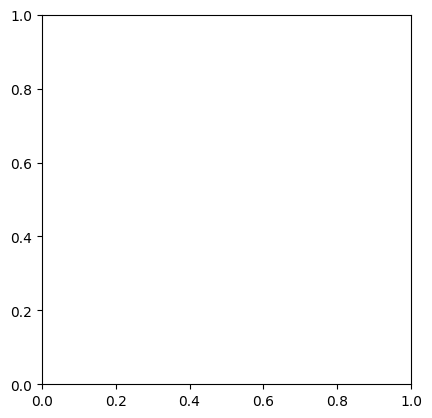

In [29]:
def fisheye_effect(image_path, output_path):
    # Read the input image
    img = cv2.imread(image_path)
    height, width = img.shape[:2]
    
    # Create the fisheye distortion matrix
    K = np.array([[width, 0, width // 2], [0, width, height // 2], [0, 0, 1]], dtype=np.float32)
    D = np.array([3, -1, 0, 0], dtype=np.float32)  # Distortion coefficients
    
    # Apply fisheye effect
    map1, map2 = cv2.fisheye.initUndistortRectifyMap(K, D, np.eye(3), K, (width, height), cv2.CV_16SC2)
    fisheye_img = cv2.remap(img, map1, map2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)
    
    # Save the output image
    cv2.imwrite(output_path, fisheye_img)

# Example usage
fisheye_effect('fisheye/1.jpg', 'output/fisheye1.jpg')
fisheye_effect('fisheye/0.5.jpg', 'output/fisheye05.jpg')


### ND32

In [10]:
def load_image_pairs(image_paths_without_filter, image_paths_with_filter):
    images_without_filter = [cv2.imread(path) for path in image_paths_without_filter]
    images_with_filter = [cv2.imread(path) for path in image_paths_with_filter]
    return images_without_filter, images_with_filter

In [11]:
def analyze_differences(images_without_filter, images_with_filter):
    diffs = []
    
    for img_without_filter, img_with_filter in zip(images_without_filter, images_with_filter):
        img_without_filter = img_without_filter.astype(np.float32)
        img_with_filter = img_with_filter.astype(np.float32)
        
        brightness_diff = img_without_filter - img_with_filter
        diffs.append(brightness_diff)
    
    # Calculate mean difference across all image pairs
    mean_diff = np.mean(diffs, axis=(0, 1, 2))
    
    return mean_diff

In [12]:
def nd32_filter(image, mean_diff):
    image = image.astype(np.float32)
    
    filtered_image = image - mean_diff
    
    filtered_image = np.clip(filtered_image, 0, 255)
    
    filtered_image = filtered_image.astype(np.uint8)
    
    return filtered_image

In [13]:
# Example usage
img_without_path = []
img_with_path = []
for i in range(1, 5):
    img_without_path.append(f'img/{i}.jpg')
for i in range(1, 5):
    img_with_path.append(f'img/{i}_nd.jpg')

In [14]:
images_without_filter, images_with_filter = load_image_pairs(img_without_path, img_with_path)
mean_diff = analyze_differences(images_without_filter, images_with_filter)

new_image = cv2.imread('img/1.jpg')
filtered_image = nd32_filter(new_image, mean_diff)

cv2.imwrite('output/1_nd32.jpg', filtered_image)


True

In [15]:
cv2.imshow('image', filtered_image)
cv2.waitKey(0)

-1

In [16]:
def plot_histograms(image, title, y_max=40000):
    colors = ('b', 'g', 'r')
    plt.figure()
    plt.title(f'Histogram for {title}')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    for i, color in enumerate(colors):
        histogram = cv2.calcHist([image], [i], None, [256], [0, 256])
        plt.plot(histogram, color=color)
        if y_max:
            plt.ylim(0, y_max)
    plt.xlim([0, 256])
    plt.show()

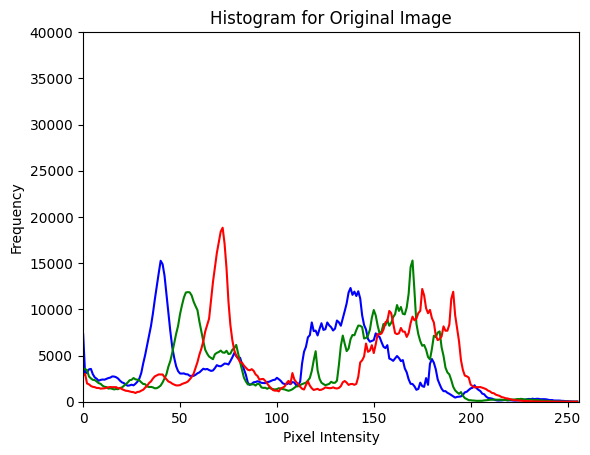

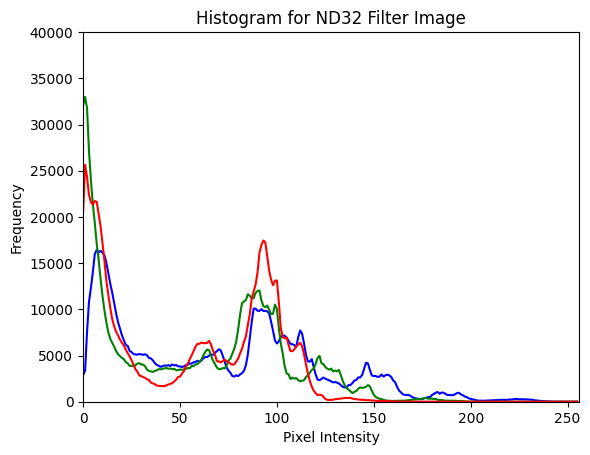

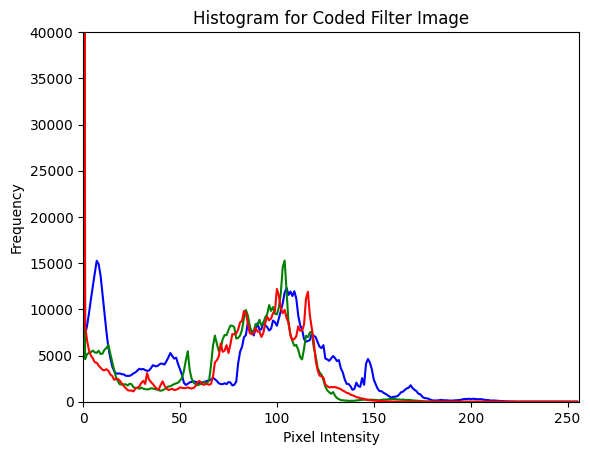

In [17]:
plot_histograms(images_without_filter[0], 'Original Image')
plot_histograms(images_with_filter[0], 'ND32 Filter Image')  # Using the first image for histogram
plot_histograms(filtered_image, 'Coded Filter Image')

### Blurry

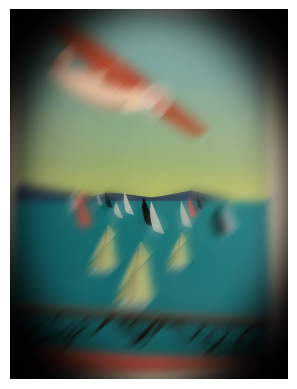

In [4]:
def add_diagonal_decal(image, decal_offset=8, decal_opacity=0.7):
    rows, cols = image.shape[:2]

    # Create the decals
    decal_up_right = np.roll(image, shift=(decal_offset, -decal_offset), axis=(0, 1))
    decal_down_left = np.roll(image, shift=(-decal_offset, decal_offset), axis=(0, 1))

    # Reduce the opacity of the decals
    decal_up_right = cv2.addWeighted(image, 1 - decal_opacity, decal_up_right, decal_opacity, 0)
    decal_down_left = cv2.addWeighted(image, 1 - decal_opacity, decal_down_left, decal_opacity, 0)

    # Combine the decals with the original image
    combined_image = cv2.addWeighted(decal_up_right, 0.5, decal_down_left, 0.5, 0)
    return combined_image

def apply_reverse_diagonal_motion_blur(image, kernel_size, intensity):
    # Create a kernel for reverse diagonal motion blur
    kernel = np.zeros((kernel_size, kernel_size))
    for i in range(kernel_size):
        kernel[i, kernel_size - i - 1] = 1
    kernel = kernel / kernel_size
    
    # Apply the motion blur multiple times to increase intensity
    blurred_image = image
    for _ in range(intensity):
        blurred_image = cv2.filter2D(blurred_image, -1, kernel)
    
    return blurred_image

def blurrier(image):
    # Create a blurred version of the image
    blurred_image = cv2.GaussianBlur(image, (5, 5), 0)
    
    motion_blurred_image = add_diagonal_decal(blurred_image)
    # Apply diagonal motion blur with increased intensity
    motion_blurred_image = apply_reverse_diagonal_motion_blur(motion_blurred_image, 15, 10)
    
    # Create a vignette effect
    rows, cols = image.shape[:2]
    kernel_x = cv2.getGaussianKernel(cols, 200)
    kernel_y = cv2.getGaussianKernel(rows, 200)
    kernel = kernel_y * kernel_x.T
    vignette_mask = 255 * kernel / np.linalg.norm(kernel)
    vignette = np.copy(image)
    
    for i in range(3):
        vignette[:, :, i] = vignette[:, :, i] * vignette_mask

    # Create a mask with smooth transition for the center focused area
    mask = np.zeros((rows, cols), np.float32)
    center_x, center_y = cols // 2, rows // 2
    radius = min(center_x, center_y) // 2

    for i in range(rows):
        for j in range(cols):
            dist = np.sqrt((i - center_y) ** 2 + (j - center_x) ** 2)
            mask[i, j] = np.clip(1 - dist / radius, 0, 1)

    mask = cv2.GaussianBlur(mask, (101, 101), 0)

    # Blend the clear and motion blurred images using the mask
    clear_region = np.copy(image).astype(np.float32)
    blurred_region = motion_blurred_image.astype(np.float32)

    combined_image = clear_region * mask[:, :, np.newaxis] + blurred_region * (1 - mask[:, :, np.newaxis])
    combined_image = combined_image.astype(np.uint8)

    return combined_image

def vignette(filename):
    ii = Im(filename=filename)
    ii.background_color = Color("black")
    ii.vignette(sigma = 70, x = 10, y = 1)
    ii.save(filename='output/blurry.jpg')
    return ii



# Load the original image
original_image_rgb = cv2.imread('no.jpg')
original_image_rgb = cv2.cvtColor(original_image_rgb, cv2.COLOR_BGR2RGB)
# Apply the smooth transition filter with more intense motion blur to the original image
intense_motion_blur_result = blurrier(original_image_rgb)
intense_motion_blur_result = np.array(intense_motion_blur_result)
cv2.imwrite('motion.jpg', cv2.cvtColor(intense_motion_blur_result, cv2.COLOR_RGB2BGR))
# Apply the vignette effect to the result
intense_motion_blur_result = vignette('motion.jpg')
# Display the result
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.title('Original Image')
# plt.imshow(original_image_rgb)
# plt.axis('off')

# plt.subplot(1, 2, 2)
# plt.title('Filtered Result with Intense Motion Blur')
plt.imshow(intense_motion_blur_result)
plt.axis('off')

plt.show()

